# Distance Measurements: Sumerian Literature

This is a work-in-progress Notebook.


In [1]:
import pandas as pd
import glob
import re
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer

# Read in Data
First read the directory with the cleaned ETCSL texts. These files contain lemmatization in ORACC (ePSD2 style). The texts list lemmatizations per line.

In [3]:
path =r'../Scrape-etcsl/cleaned/' # use your path
allFiles = glob.glob(path + "/*.txt")
list_ = []
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
etcsl_data = pd.concat(list_)
#etcsl_data

# Create Document Term Matrix
In order to transform this DataFrame into a proper Document Term Matrix we need to discard the columns `version` and `l_no` and concatenate all the text that belongs to a single composition. Some lines have no content in the `text` column - these lines need to be dropped.

First select the relevant columns and drop the rows that have no text content.

In [4]:
etcsl_data = etcsl_data[['id_text', 'text_name', 'text']]
etcsl_data = etcsl_data.dropna()
etcsl_data.head()

,id_text,text_name,text
0,c.0.1.1,Ur III catalogue from Nibru (N1),sux:dubsaŋ[first]AJ
1,c.0.1.1,Ur III catalogue from Nibru (N1),sux:Enki[1]DN sux:unu[dwelling]N sux:gal[big]V...
2,c.0.1.1,Ur III catalogue from Nibru (N1),sux:anzag[horizon]N
3,c.0.1.1,Ur III catalogue from Nibru (N1),sux:anŋi[eclipse]N sux:zu[know]V/t sux:ama[mot...
4,c.0.1.1,Ur III catalogue from Nibru (N1),sux:gi[thicket]N sux:tuku[rock]V/t


Group the rows by `id_text` and apply the `join` function to the `text` column. Transform the aggregated data into a new DataFrame.

In [5]:
etcsl_bytext = etcsl_data['text'].groupby(etcsl_data['id_text']).apply(' '.join)
etcsl_bytext_df = pd.DataFrame(etcsl_bytext)
etcsl_bytext_df.head()

,text
id_text,
c.0.1.1,sux:dubsaŋ[first]AJ sux:Enki[1]DN sux:unu[dwel...
c.0.1.2,sux:diŋir[deity]N sux:šembizida[kohl]N sux:dar...
c.0.2.01,sux:lugal[king]N sux:šag[heart]N sux:lugal[kin...
c.0.2.02,sux:Enlil[1]DN sux:sud[distant]V/i sux:nam[lor...
c.0.2.03,sux:lugal[king]N sux:mu[name]N sux:niŋul[everl...


Create a DataFrame of `id_text` and `text_name` equivalencies, with `id_text` set as index (row names). Then merge this DataFrame with the the `etctsl_bytext_df` using the indexes.

In [6]:
etcsl_id_names = etcsl_data[['id_text', 'text_name']].drop_duplicates().set_index('id_text')
etcsl_data_df = pd.merge(etcsl_id_names, etcsl_bytext_df, right_index=True, left_index=True)
etcsl_data_df.head()

,text_name,text
id_text,,
c.0.1.1,Ur III catalogue from Nibru (N1),sux:dubsaŋ[first]AJ sux:Enki[1]DN sux:unu[dwel...
c.0.1.2,Ur III catalogue at Yale (Y1),sux:diŋir[deity]N sux:šembizida[kohl]N sux:dar...
c.0.2.01,OB catalogue from Nibru (N2),sux:lugal[king]N sux:šag[heart]N sux:lugal[kin...
c.0.2.02,OB catalogue in the Louvre (L),sux:Enlil[1]DN sux:sud[distant]V/i sux:nam[lor...
c.0.2.03,OB catalogue from Urim (U1),sux:lugal[king]N sux:mu[name]N sux:niŋul[everl...


Transfrom the DataFrame into a Document Term Matrix (DTM) by using `CountVecorizer`. This function uses a Regular Expression (`token_pattern`) to indicate how to find the beginning and end of each word (or token). In lemmatized Sumerian, a space indicates the boundary between two lemmas. The expression `r.[^ ]+` means: any combination of characters, except the space.

The output of the CountVectorizer (`etcsl_dtm`) is not in a human-readable format. It is transformed into another DataFrame, with the ETCSL numbers as index.

In [7]:
cv = CountVectorizer(analyzer='word', token_pattern=r'[^ ]+')
etcsl_dtm = cv.fit_transform(etcsl_data_df['text'])
etcsl_dtm_df = pd.DataFrame(etcsl_dtm.toarray(), columns = cv.get_feature_names(), index = etcsl_data_df.index.values)
etcsl_dtm_df.head()

,sux-x-emesal:ammuš[three]nu,sux-x-emesal:aŋ[do]v/t,sux-x-emesal:aŋ[sky]n,sux-x-emesal:aŋ[thing]n,sux-x-emesal:aŋba[gift]n,sux-x-emesal:aŋdara[rag]n,sux-x-emesal:aŋgig[bad-thing]n,sux-x-emesal:aŋhulu[evil]n,sux-x-emesal:aŋlam[garment]n,sux-x-emesal:aŋsub[polishing]n,...,sux:šuteŋ[accept]v/t,sux:šutubur[mixture]n,sux:šutug[reed-hut]n,sux:šutum[storehouse]n,sux:šutur[garment]n,sux:šuziana[1]dn,sux:šuš[cover]v/t,sux:šuʾi[barber]n,sux:šuʾu[stone]n,sux:šuʾura[goose]n
c.0.1.1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.1.2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.01,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.02,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
c.0.2.03,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


# Compute Text Length
The length of each composition in ETCSL may be computed by adding up all the numbers in a row of the Document Term Matrix. The text length will be used at various places in further computations. Text length is added as a column to etcsl_data_df for future use.

In [8]:
etcsl_data_df['length'] =  etcsl_dtm_df.sum(axis=1)
etcsl_data_df.head()

,text_name,text,length
id_text,,,
c.0.1.1,Ur III catalogue from Nibru (N1),sux:dubsaŋ[first]AJ sux:Enki[1]DN sux:unu[dwel...,54
c.0.1.2,Ur III catalogue at Yale (Y1),sux:diŋir[deity]N sux:šembizida[kohl]N sux:dar...,147
c.0.2.01,OB catalogue from Nibru (N2),sux:lugal[king]N sux:šag[heart]N sux:lugal[kin...,160
c.0.2.02,OB catalogue in the Louvre (L),sux:Enlil[1]DN sux:sud[distant]V/i sux:nam[lor...,183
c.0.2.03,OB catalogue from Urim (U1),sux:lugal[king]N sux:mu[name]N sux:niŋul[everl...,59


# Normalize
Each row in the Document Term Matrix may be perceived as a vector with 4296 positions. The length of each vector depends on the number of lemmatized words. In order to make the vectors more comparable, we may set vector length at 1. This is done by dividing each value by the length of the vector, which equals the square root of the sum of the squared values: 

vector length = $\sqrt{\sum_{i=1}^nX^2_i}$.

We now have two versions of the same Document Term Matrix: `etcsl_dtm_df` (with regular vocabulary counts) and `etcsl_dtm_df_norm` with normalized counts.

In [9]:
etcsl_dtm_df_norm = etcsl_dtm_df.apply(lambda x: (x / np.sqrt(sum(np.square(x)))), axis = 1)

# Eliminate very short compositions
Some of the compositions in [ETCSL](etcsl.orinst.ox.ac.uk) are very short because they are only known from catalog texts or they exist only in a single (fragmentary) exemplar. Normalizing will dramatically increase the weight of the few words that appear in those texts. In addition to normalizing, therefore, we will also eliminate texts that have fewer than 50 lemmatized words. The regular DTM (`etcsl_dtm_df`) still contains all 394 compositions.

The following 39 compositions have been eliminated from the normalized DTM (listed by length of the composition).

In [10]:
etcsl_dtm_df_norm = etcsl_dtm_df_norm[etcsl_data_df['length'] > 49]
etcsl_data_df[['text_name', 'length']][etcsl_data_df['length'] < 50].sort_values(by='length')

,text_name,length
id_text,,
c.2.4.4.9,A praise poem of Šu-Suen (Šu-Suen I),4
c.4.27.a,A hymn to Ninurta,5
c.3.1.13.1,Letter from Šulgi (?) to Aradŋu about troops,6
c.2.8.3.4,A prayer for Samsu-iluna (Samsu-iluna D),6
c.2.5.2.3,An adab for Šu-ilīšu (Šu-ilīšu C),9
c.4.08.12,A song of Inana and Dumuzid (Dumuzid-Inana L),14
c.2.99.b,A fragment of a royal praise poem,15
c.2.99.c,A fragment of a royal praise poem,19
c.2.4.1.8,A praise poem of Ur-Namma (Ur-Namma H),21


# Distances and Clustering
From here on use the explanations in the blog by [Jörn Hees](https://joernhees.de/blog/2015/08/26/scipy-hierarchical-clustering-and-dendrogram-tutorial/) for hierarchical clustering and creating dendrograms for step 1 of the clustering analysis (step 2 is K-means clustering). Check also the text clustering Notebook by [Brandon Rose](http://brandonrose.org/clustering), which combines K-means, hierarchical clustering and topic modeling.

In [11]:
from matplotlib import pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage, ward
from scipy.cluster.hierarchy import cophenet
from scipy.spatial.distance import pdist, squareform
from pygal import *

#import numpy as np

In [12]:
# some setting for this notebook to actually show the graphs inline, you probably won't need this. Disable the %matplotlib line in order to get 
# the interactive matplotlib GUI.
%matplotlib inline
np.set_printoptions(precision=5, suppress=True)  # suppress scientific float notation

# The function dendro()

The function `dendro()` draws a dendrogram of a hierarchical clustering analysis, using the Ward method for the linkage and Euclidean distances. The `dendro()` function will be used to try different approaches to hierarchical clustering: clustering the entire corpus in raw counts; clustering with normalized vectors; and clustering with `tf-idf` weighted count. In addition, the function is used to cluster a sub-corpus: the heroic narratives around Gilgamesh, Enmerkar, and Lugalbanda.

The `dendro()` function draws a horizontal dendrogram. It takes four parameters: the DTM that is to be analyzed; the labels to be used for each data point (a list, to be derived from the DTM), the label to be printed along the Y-axis (describing the dataset), and the height of the figure (an integer). The analysis of the entire corpus will produce a very large image. Right click the nimage and open it in a new browser to inspect it in more detail.

The function returns the linkage matrix Z, which may be used in computing the Cophenetic Correlation Coefficient.

In [13]:
def dendro(dtm, labels, ylabel, heigth = 10):
# generate the linkage matrix
    Z = linkage(dtm, 'ward')
# calculate full dendrogram
    plt.figure(figsize=(25, heigth))
    plt.title('Hierarchical Clustering Dendrogram')
    plt.xlabel('distance')
    plt.ylabel(ylabel)
    dendrogram(
        Z,
        labels = labels,
        orientation = 'right',
#        leaf_rotation=90.,  # rotates the x axis labels
        leaf_font_size=10.,  # font size for the x axis labels
    )
    plt.show()
    return Z

In [14]:
#Z = dendro(etcsl_dtm_df, etcsl_data_df['text_name'], 'full etcsl corpus\nno normalization', 50)
#c, coph_dists = cophenet(Z, pdist(etcsl_dtm_df))
#c
print(linkage(etcsl_dtm_df, 'ward'))

[[ 100.       323.         2.64575    2.     ]
 [ 176.       394.         3.41565    3.     ]
 [ 199.       395.         3.85141    4.     ]
 ..., 
 [  49.       783.       394.18614   60.     ]
 [ 779.       784.       477.12669   62.     ]
 [ 773.       785.       743.72686  394.     ]]


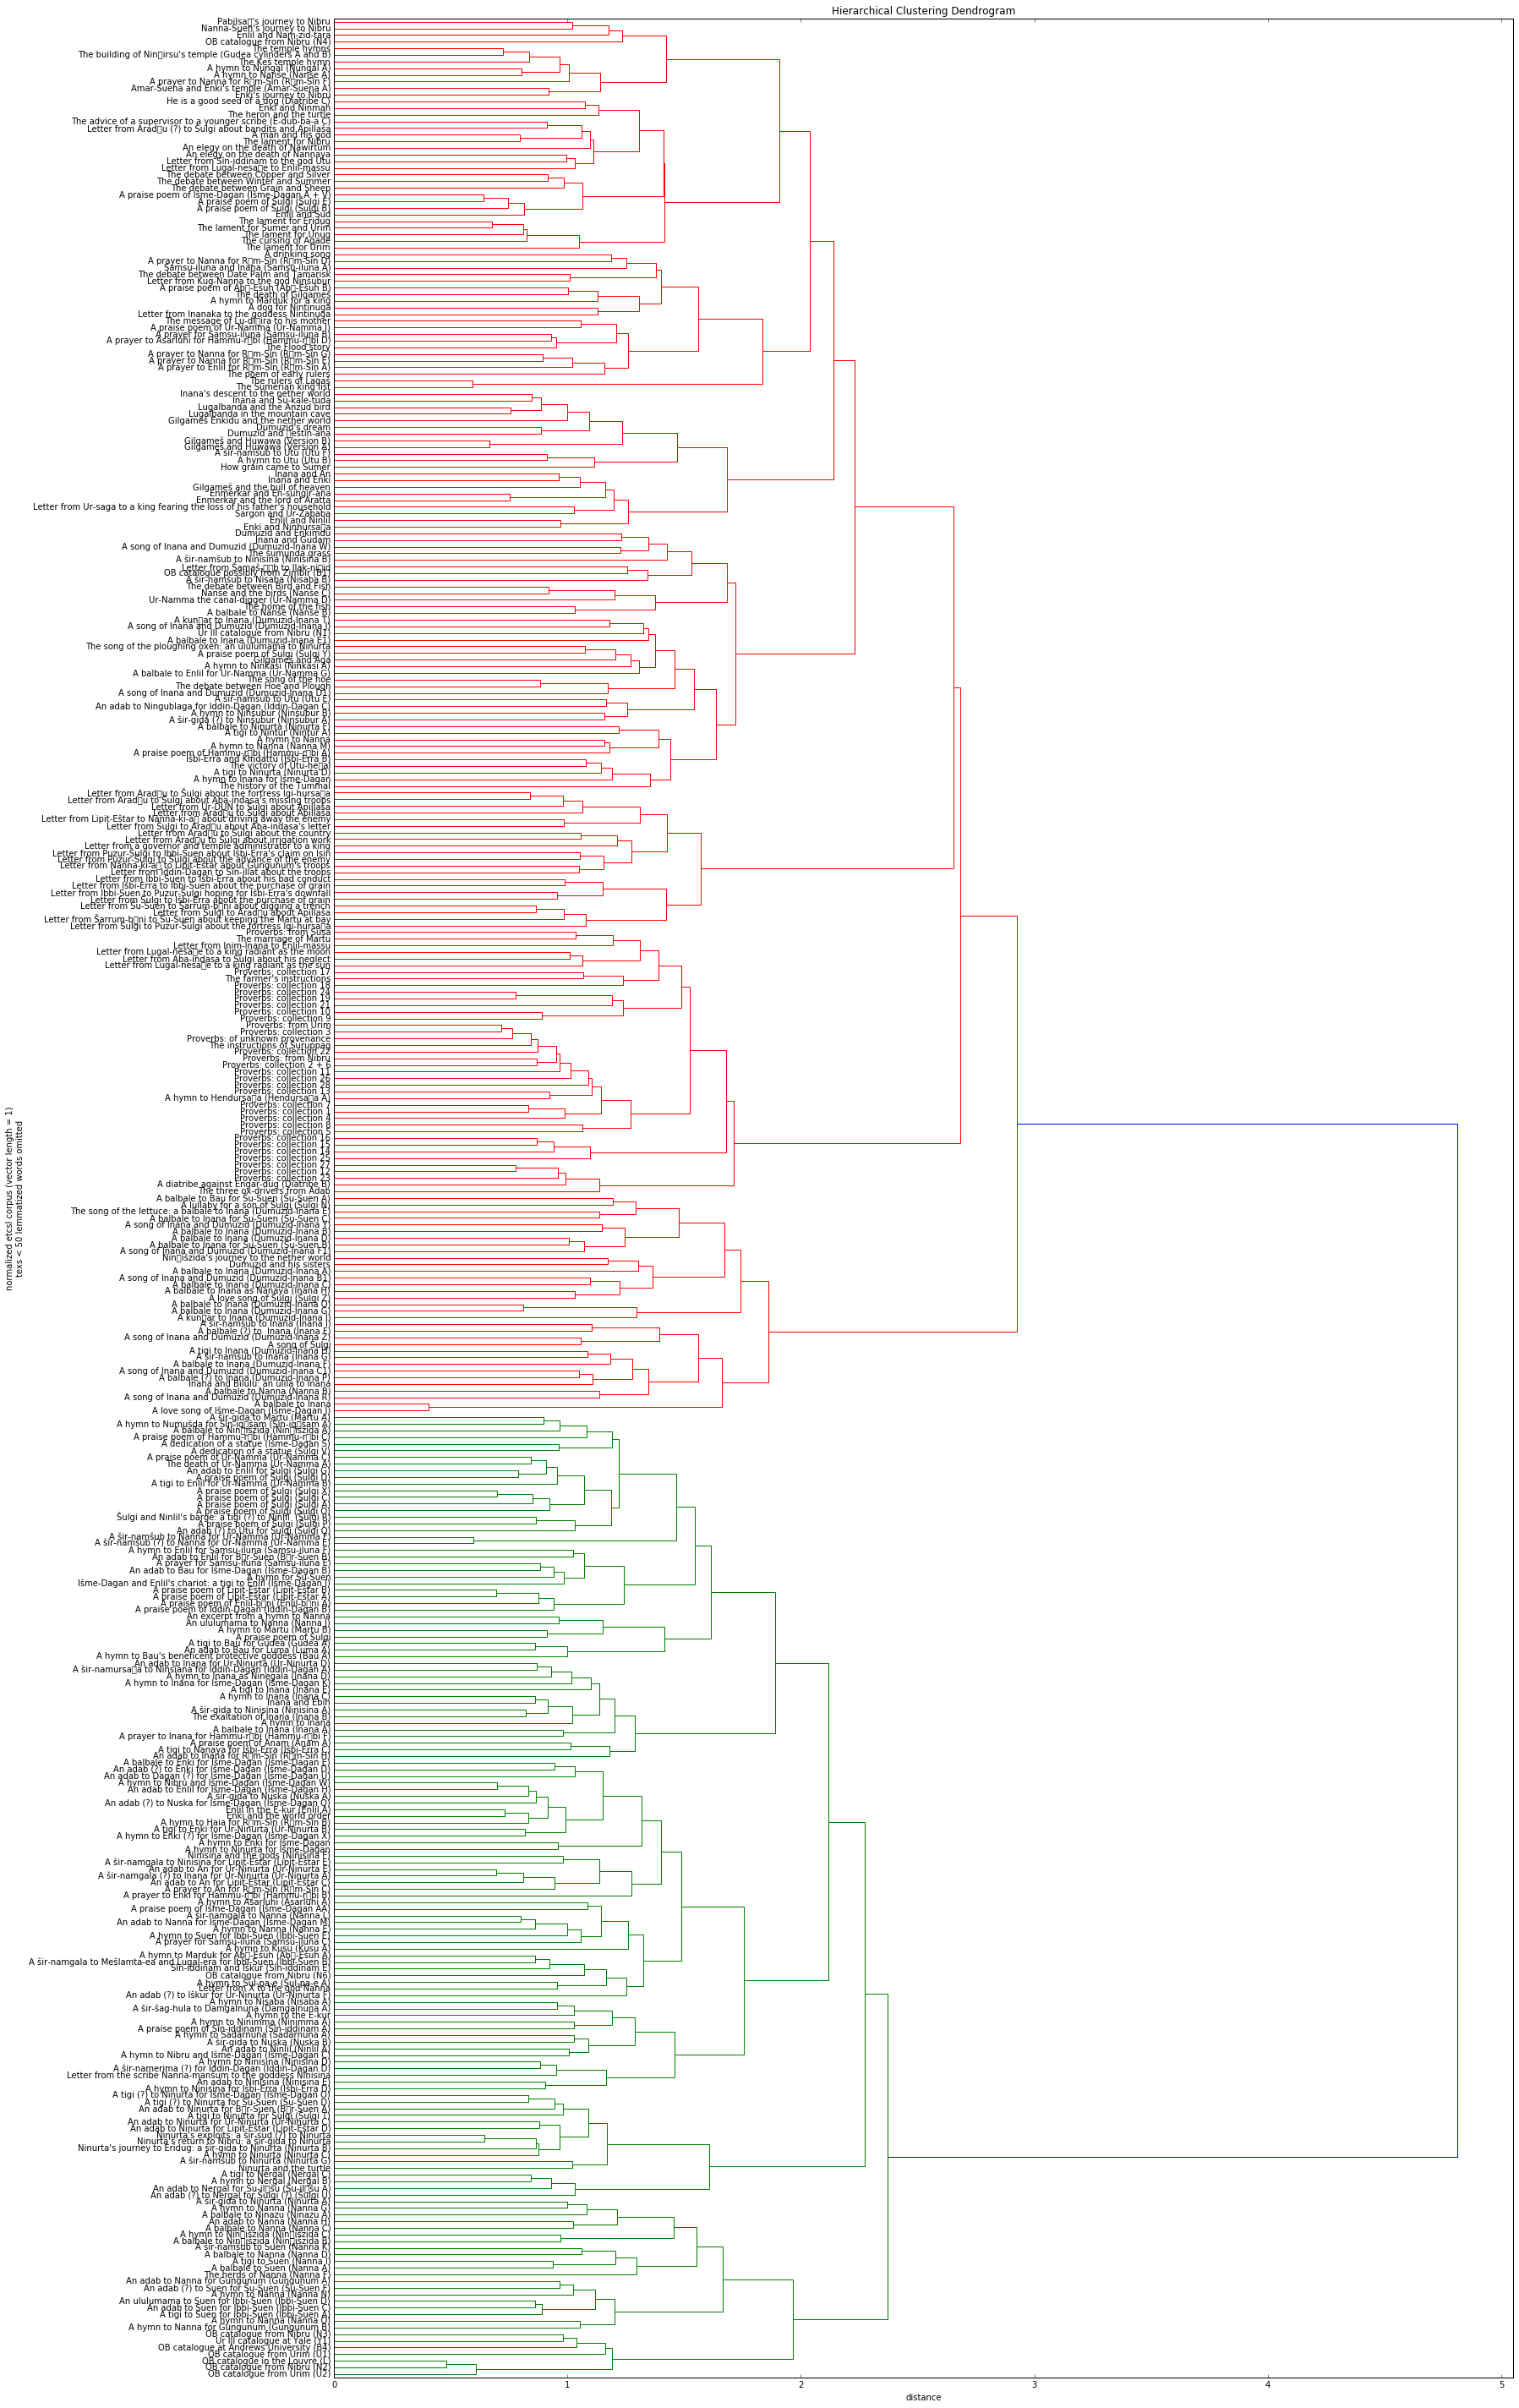

0.25224989626818362

In [15]:
labels = etcsl_data_df['text_name'][etcsl_data_df['length'] > 49]
Z = dendro(etcsl_dtm_df_norm, labels, 'normalized etcsl corpus (vector length = 1)\ntexs < 50 lemmatized words omitted', 50)
c, coph_dists = cophenet(Z, pdist(etcsl_dtm_df_norm))
c


# Testing

In [16]:
import pygal                                                       # First import pygal
#labels = etcsl_data_df['text_name'][etcsl_data_df['length'] > 49]
#Z = dendro(etcsl_dtm_df_norm, labels, 'normalized etcsl corpus (vector length = 1)\ntexs < 50 lemmatized words omitted', 50)
#c, coph_dists = cophenet(Z, pdist(etcsl_dtm_df_norm))
#c
#chart = pygal.Line(Z)
#chart = pygal.Line()
#chart.render_to_png('\Users\Swoop\Downloads\Research\Digital-Assyriology-test\ETCSL-distance-clustering\cluster.png')


bar_chart = pygal.Bar()                                            # Then create a bar graph object
bar_chart.add('Fibonacci', [0, 1, 1, 2, 3, 5, 8, 13, 21, 34, 55])  # Add some values
bar_chart.render_to_file('bar_chart.svg')                          # Save the svg to a file

# Select
Select only the Gilgamesh, Enmerkar and Lugalbanda stories.

In [17]:
heroic = ['c.1.8.1.1', 'c.1.8.1.2', 'c.1.8.1.3', 'c.1.8.1.4', 'c.1.8.1.5', 'c.1.8.1.5.1', 'c.1.8.2.1', 
          'c.1.8.2.2', 'c.1.8.2.3', 'c.1.8.2.4'
         ]
labels = list(etcsl_data_df.ix[heroic]['text_name'])


Compute a distance matrix [or perhaps skip this step]

In [18]:
X = etcsl_dtm_df.ix[heroic]
dist = pdist(X)
heroic_dist_df = pd.DataFrame(squareform(dist)).round(2)
heroic_dist_df.index = labels
heroic_dist_df.columns = labels
heroic_dist_df

,Gilgameš and Aga,Gilgameš and the bull of heaven,The death of Gilgameš,Gilgameš Enkidu and the nether world,Gilgameš and Huwawa (Version A),Gilgameš and Huwawa (Version B),Lugalbanda in the mountain cave,Lugalbanda and the Anzud bird,Enmerkar and the lord of Aratta,Enmerkar and En-suhgir-ana
Gilgameš and Aga,0.00,89.30,132.18,220.24,103.41,57.83,146.04,137.86,213.64,104.44
Gilgameš and the bull of heaven,89.30,0.00,136.77,216.15,107.56,89.87,140.78,137.60,199.42,108.73
The death of Gilgameš,132.18,136.77,0.00,210.01,132.37,128.79,136.94,143.46,198.05,130.07
Gilgameš Enkidu and the nether world,220.24,216.15,210.01,0.00,196.53,213.62,190.50,196.95,243.22,209.29
Gilgameš and Huwawa (Version A),103.41,107.56,132.37,196.53,0.00,79.32,119.66,114.09,194.25,109.59
Gilgameš and Huwawa (Version B),57.83,89.87,128.79,213.62,79.32,0.00,133.91,130.41,209.75,103.41
Lugalbanda in the mountain cave,146.04,140.78,136.94,190.50,119.66,133.91,0.00,115.96,179.21,125.62
Lugalbanda and the Anzud bird,137.86,137.60,143.46,196.95,114.09,130.41,115.96,0.00,178.22,114.47
Enmerkar and the lord of Aratta,213.64,199.42,198.05,243.22,194.25,209.75,179.21,178.22,0.00,167.76
Enmerkar and En-suhgir-ana,104.44,108.73,130.07,209.29,109.59,103.41,125.62,114.47,167.76,0.00


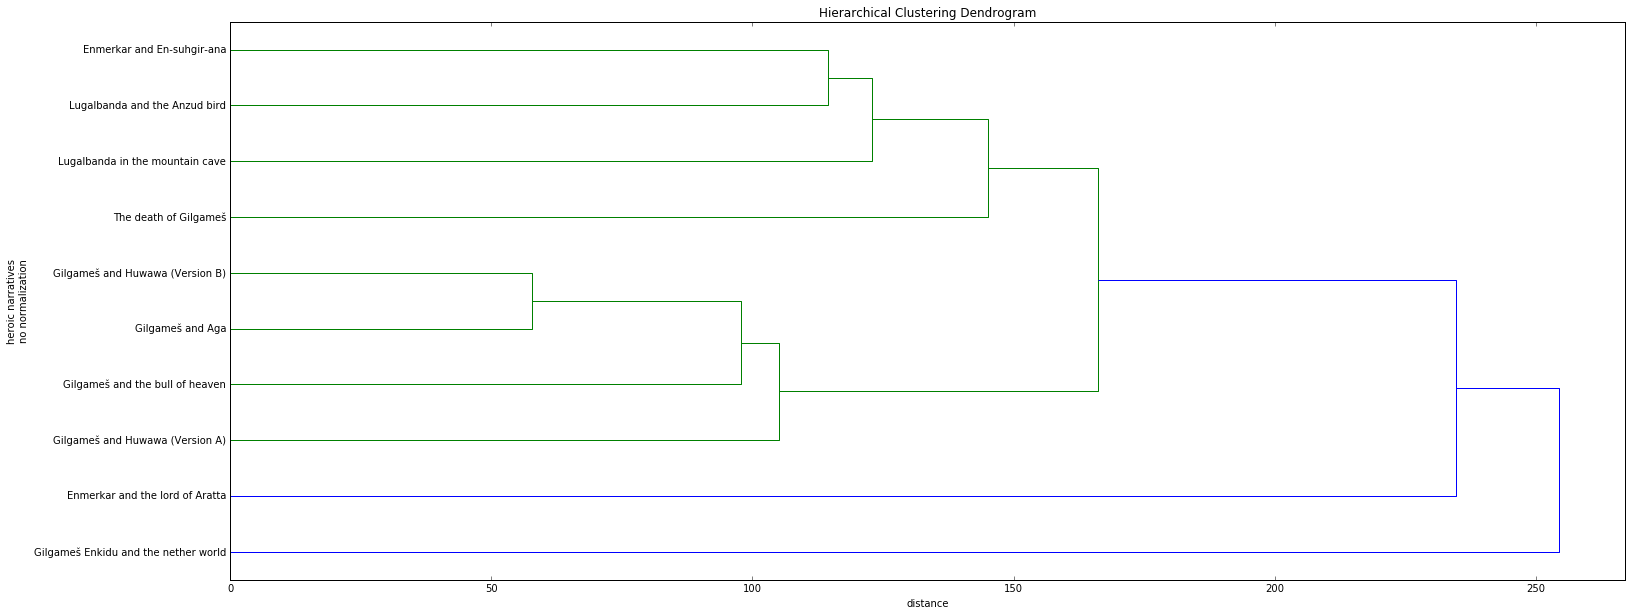

In [19]:
Z = dendro(etcsl_dtm_df.ix[heroic], labels, 'heroic narratives\nno normalization')

# Normalized

In [20]:
X = etcsl_dtm_df_norm.ix[heroic]
dist = pdist(X)
heroic_dist_df = pd.DataFrame(squareform(dist)).round(2)
heroic_dist_df.index = labels
heroic_dist_df.columns = labels
heroic_dist_df

,Gilgameš and Aga,Gilgameš and the bull of heaven,The death of Gilgameš,Gilgameš Enkidu and the nether world,Gilgameš and Huwawa (Version A),Gilgameš and Huwawa (Version B),Lugalbanda in the mountain cave,Lugalbanda and the Anzud bird,Enmerkar and the lord of Aratta,Enmerkar and En-suhgir-ana
Gilgameš and Aga,0.00,1.10,1.09,1.16,1.09,1.10,1.13,1.10,1.09,1.10
Gilgameš and the bull of heaven,1.10,0.00,1.09,1.13,1.02,1.11,1.04,1.06,1.00,1.03
The death of Gilgameš,1.09,1.09,0.00,1.04,1.01,1.04,0.91,0.97,0.98,0.99
Gilgameš Enkidu and the nether world,1.16,1.13,1.04,0.00,0.97,1.05,0.92,0.96,1.05,1.06
Gilgameš and Huwawa (Version A),1.09,1.02,1.01,0.97,0.00,0.67,0.84,0.83,0.97,0.97
Gilgameš and Huwawa (Version B),1.10,1.11,1.04,1.05,0.67,0.00,0.93,0.98,1.03,1.08
Lugalbanda in the mountain cave,1.13,1.04,0.91,0.92,0.84,0.93,0.00,0.75,0.86,0.88
Lugalbanda and the Anzud bird,1.10,1.06,0.97,0.96,0.83,0.98,0.75,0.00,0.86,0.83
Enmerkar and the lord of Aratta,1.09,1.00,0.98,1.05,0.97,1.03,0.86,0.86,0.00,0.75
Enmerkar and En-suhgir-ana,1.10,1.03,0.99,1.06,0.97,1.08,0.88,0.83,0.75,0.00


In [21]:
a = heroic_dist_df.columns.values.tolist()
print(a)
b = heroic_dist_df.index.values.tolist()
print(b)
c = heroic_dist_df['Gilgameš and Aga']
print(list(c))

treemap = pygal.Treemap()
treemap.title = 'Binary TreeMap'
treemap.add('Gilgameš and Aga', heroic_dist_df['Gilgameš and Aga'])
treemap.add('Gilgameš and the bull of heaven', heroic_dist_df['Gilgameš and the bull of heaven'])
treemap.add('The death of Gilgameš', heroic_dist_df['The death of Gilgameš'])
treemap.add('Gilgameš Enkidu and the nether world', heroic_dist_df['Gilgameš Enkidu and the nether world'])
treemap.add('Gilgameš and Huwawa (Version A)', heroic_dist_df['Gilgameš and Huwawa (Version A)'] )
treemap.add('Lugalbanda in the mountain cave', heroic_dist_df['Lugalbanda in the mountain cave'])
treemap.add('Lugalbanda and the Anzud bird', heroic_dist_df['Lugalbanda and the Anzud bird'])ds
treemap.add('Enmerkar and the lord of Aratta', heroic_dist_df['Enmerkar and the lord of Aratta'])
treemap.add('Enmerkar and En-suhgir-ana', heroic_dist_df['Enmerkar and En-suhgir-ana'])
treemap.render()

treemap.render_to_file('treemaptest.svg')

treemap.add('Gilgameš and Aga', [{'value': 0.00, 'label': 'Gilgameš and Aga'}, {'value': 1.10, 'label': 'Gilgameš and the bull of heaven'}, {'value': 1.09, 'label': 'The death of Gilgameš'}])


def svg_tree_map_creater(dataset, svg_file_title):
    columns = dataset.columns.tolist()
    rows = dataset_dist_df.index.values.tolist()
    treemap = pygal.Treemap()
    treemap.title = str(svg_file_title)
    for i in range(0, len(columns)):
        values = dataset[rows[i]]
        for i range(0,len(rows)):
            treemap.add(rows[i], 
    treemap.render()
    treemap.render_to_file(str(svg_file_title)+'.svg')
    

        

SyntaxError: invalid syntax (<ipython-input-21-8d50170f80eb>, line 33)

In [24]:
a = heroic_dist_df.columns.values.tolist()
print(a)
b = heroic_dist_df.index.values.tolist()
print(b)
c = heroic_dist_df['Gilgameš and Aga']
list(c)

treemap = pygal.Treemap()
treemap.title = 'Binary TreeMap'
treemap.add('Gilgameš and Aga', [{'value': 0.00, 'label': 'Gilgameš and Aga'}, {'value': 1.10, 'label': 'Gilgameš and the bull of heaven'}, {'value': 1.09, 'label': 'The death of Gilgameš'}])
treemap.add('Gilgameš and the bull of heaven', heroic_dist_df['Gilgameš and the bull of heaven'])
treemap.add('The death of Gilgameš', heroic_dist_df['The death of Gilgameš'])
treemap.add('Gilgameš Enkidu and the nether world', heroic_dist_df['Gilgameš Enkidu and the nether world'])
treemap.add('Gilgameš and Huwawa (Version A)', heroic_dist_df['Gilgameš and Huwawa (Version A)'] )
treemap.add('Lugalbanda in the mountain cave', heroic_dist_df['Lugalbanda in the mountain cave'])
treemap.add('Lugalbanda and the Anzud bird', heroic_dist_df['Lugalbanda and the Anzud bird'])
treemap.add('Enmerkar and the lord of Aratta', heroic_dist_df['Enmerkar and the lord of Aratta'])
treemap.add('Enmerkar and En-suhgir-ana', heroic_dist_df['Enmerkar and En-suhgir-ana'])
treemap.render()
treemap.render_to_file('treemaptest.svg')  

####################################################################################################################################
radar = pygal.Radar()
radar.title = 'Binary Radar'
radar.x_labels = ['Gilgameš and Aga', 'Gilgameš and the bull of heaven', 'The death of Gilgameš', 'Gilgameš Enkidu and the nether world', 
                  'Gilgameš and Huwawa (Version A)', 'Lugalbanda in the mountain cave', 'Lugalbanda and the Anzud bird', 'Enmerkar and the lord of Aratta',
'Enmerkar and En-suhgir-ana']
radar.add('Gilgameš and Aga', [{'value': 0.00, 'label': 'Gilgameš and Aga'}, {'value': 1.10, 'label': 'Gilgameš and the bull of heaven'}, {'value': 1.09, 'label': 'The death of Gilgameš'}] )
radar.add('Gilgameš and the bull of heaven', heroic_dist_df['Gilgameš and the bull of heaven'])
radar.add('The death of Gilgameš', heroic_dist_df['The death of Gilgameš'])
radar.add('Gilgameš Enkidu and the nether world', heroic_dist_df['Gilgameš Enkidu and the nether world'])
radar.add('Gilgameš and Huwawa (Version A)', heroic_dist_df['Gilgameš and Huwawa (Version A)'] )
radar.add('Lugalbanda in the mountain cave', heroic_dist_df['Lugalbanda in the mountain cave'])
radar.add('Lugalbanda and the Anzud bird', heroic_dist_df['Lugalbanda and the Anzud bird'])
radar.add('Enmerkar and the lord of Aratta', heroic_dist_df['Enmerkar and the lord of Aratta'])
radar.add('Enmerkar and En-suhgir-ana', heroic_dist_df['Enmerkar and En-suhgir-ana'])
radar.render()
radar.render_to_file('radar_test.svg')  


###################################################################################################################################

dot_chart = pygal.Dot(x_label_rotation=30)
dot_chart.title = 'Binary Dot_Chart'
dot_chart.x_labels = ['Gilgameš and Aga', 'Gilgameš and the bull of heaven', 'The death of Gilgameš', 'Gilgameš Enkidu and the nether world', 
                  'Gilgameš and Huwawa (Version A)', 'Lugalbanda in the mountain cave', 'Lugalbanda and the Anzud bird', 'Enmerkar and the lord of Aratta',
'Enmerkar and En-suhgir-ana']
dot_chart.x_labels = ['Gilgameš and Aga', 'Gilgameš and the bull of heaven', 'The death of Gilgameš', 'Gilgameš Enkidu and the nether world', 
                  'Gilgameš and Huwawa (Version A)', 'Lugalbanda in the mountain cave', 'Lugalbanda and the Anzud bird', 'Enmerkar and the lord of Aratta',
'Enmerkar and En-suhgir-ana']
dot_chart.add('Gilgameš and Aga', [{'value': 0.00, 'label': 'Gilgameš and Aga'}, {'value': 1.10, 'label': 'Gilgameš and the bull of heaven'}, {'value': 1.09, 'label': 'The death of Gilgameš'}] )
dot_chart.add('Gilgameš and the bull of heaven', heroic_dist_df['Gilgameš and the bull of heaven'])
dot_chart.add('The death of Gilgameš', heroic_dist_df['The death of Gilgameš'])
dot_chart.add('Gilgameš Enkidu and the nether world', heroic_dist_df['Gilgameš Enkidu and the nether world'])
dot_chart.add('Gilgameš and Huwawa (Version A)', heroic_dist_df['Gilgameš and Huwawa (Version A)'] )
dot_chart.add('Lugalbanda in the mountain cave', heroic_dist_df['Lugalbanda in the mountain cave'])
dot_chart.add('Lugalbanda and the Anzud bird', heroic_dist_df['Lugalbanda and the Anzud bird'])
dot_chart.add('Enmerkar and the lord of Aratta', heroic_dist_df['Enmerkar and the lord of Aratta'])
dot_chart.add('Enmerkar and En-suhgir-ana', heroic_dist_df['Enmerkar and En-suhgir-ana'])
dot_chart.render()
dot_chart.render_to_file('dot_chart_test.svg')  

#0.00, 1.10, 1.09, 1.16, 1.09, 1.10, 1.13, 1.10, 1.09, 1.10
################################################################################################################################
chart = pygal.Bar()
chart.add('First', [{'value': 2, 'label': 'This is the first'}])
chart.add('Second', [{'value': 4, 'label': 'This is the second'}])
chart.add('Third', 7)
chart.add('Fourth', [{'value': 5}])
chart.add('Fifth', [{'value': 3, 'label': 'This is the fifth'}])
chart.render()



['Gilgameš and Aga', 'Gilgameš and the bull of heaven', 'The death of Gilgameš', 'Gilgameš Enkidu and the nether world', 'Gilgameš and Huwawa (Version A)', 'Gilgameš and Huwawa (Version B)', 'Lugalbanda in the mountain cave', 'Lugalbanda and the Anzud bird', 'Enmerkar and the lord of Aratta', 'Enmerkar and En-suhgir-ana']
['Gilgameš and Aga', 'Gilgameš and the bull of heaven', 'The death of Gilgameš', 'Gilgameš Enkidu and the nether world', 'Gilgameš and Huwawa (Version A)', 'Gilgameš and Huwawa (Version B)', 'Lugalbanda in the mountain cave', 'Lugalbanda and the Anzud bird', 'Enmerkar and the lord of Aratta', 'Enmerkar and En-suhgir-ana']


b'<?xml version=\'1.0\' encoding=\'utf-8\'?>\n<svg xmlns:xlink="http://www.w3.org/1999/xlink" xmlns="http://www.w3.org/2000/svg" id="chart-2d70d6fe-c045-4d46-9f2d-dbe19960dba4" class="pygal-chart" viewBox="0 0 800 600"><!--Generated with pygal 2.3.0 (lxml) \xc2\xa9Kozea 2012-2016 on 2016-11-18--><!--http://pygal.org--><!--http://github.com/Kozea/pygal--><defs><style type="text/css">#chart-2d70d6fe-c045-4d46-9f2d-dbe19960dba4{-webkit-user-select:none;-webkit-font-smoothing:antialiased;font-family:Consolas,"Liberation Mono",Menlo,Courier,monospace}#chart-2d70d6fe-c045-4d46-9f2d-dbe19960dba4 .title{font-family:Consolas,"Liberation Mono",Menlo,Courier,monospace;font-size:16px}#chart-2d70d6fe-c045-4d46-9f2d-dbe19960dba4 .legends .legend text{font-family:Consolas,"Liberation Mono",Menlo,Courier,monospace;font-size:14px}#chart-2d70d6fe-c045-4d46-9f2d-dbe19960dba4 .axis text{font-family:Consolas,"Liberation Mono",Menlo,Courier,monospace;font-size:10px}#chart-2d70d6fe-c045-4d46-9f2d-dbe19960dba

In [ ]:
Z = dendro(etcsl_dtm_df_norm.ix[heroic], labels, 'heroic narratives normalized')

Is this due to personal names? Apparently not.

In [ ]:
heroic_dtm = etcsl_dtm_df_norm.ix[heroic]

In [ ]:
qpn = {'cn', 'dn', 'en', 'fn', 'gn', 'mn', 'on', 'pn', 'rn', 'sn', 'tn', 'wn'}
words = heroic_dtm.columns
words_no_names = [word for word in words if not word[-2:] in qpn]

In [ ]:
heroic_no_names_dtm = heroic_dtm[words_no_names]

In [22]:
Z = dendro(heroic_no_names_dtm, labels, 'heroic narratives normalized \n no proper names')

NameError: name 'heroic_no_names_dtm' is not defined

# Testing

the entire dendrogram without proper names

In [ ]:
words = etcsl_dtm_df_norm.columns
words_no_names = [word for word in words if not word[-2:] in qpn]
etcsl_no_names_dtm = etcsl_dtm_df_norm[words_no_names]
labels = etcsl_data_df['text_name'][etcsl_data_df['length'] > 49]
Z = dendro(etcsl_no_names_dtm, labels, 'etcsl normalized \n no proper names', 50)

# TF-IDF
tf-idf is an alternative vectorizer that weighs words and normalizes for text length. Texts that are too short (< 50 lemmatized words) are omitted before applying `tf-idf`. Among the settings for `tf-idf` are `max_df` and `min_df` or maximum and minimum document frequency. Document frequency refers to the percentage of the documents that contain a certain term at least once. Common values are 80% and 20% - that is, terms that appear in more than 80% or less than 20% of the documents in the corpus are excluded from the analysis. This setting excludes far too many words for the present purpose (it keeps only 178 out of more than 4,200 unique words). Currently `max_df` and `min_df` are set to 98% and 2%, respectively (keeping 1185 unique terms) - but more research is needed to find an appropriate setting.

In [ ]:
long = etcsl_data_df['length'] > 49
etcsl_noshort_df = etcsl_data_df[long]

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.98, max_features=200000,
                                 min_df=0.02,
                                 use_idf=True, token_pattern=r'[^ ]+', ngram_range=(1,1))
tfidf_matrix = tfidf_vectorizer.fit_transform(etcsl_noshort_df['text'])
etcsl_tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names(), 
                              index = etcsl_noshort_df.index.values)
etcsl_tfidf_df.head()
etcsl_tfidf_df.columns.values.tolist()


In [ ]:
def create_tf_idf_list(dataset):
    dataframe_words_list = []
    for i in range(0, len(dataset)):
        word = dataset[i]
        word = word[4:len(word)]
        number_check = word[0]
        if number_check.isdigit():
            continue
        else:
            dataframe_words_list.append(word)
    return(dataframe_words_list)


def tf_idf_function(dataset, max_freq, min_freq, ngram_a, ngram_b):
    if (max_freq + min_freq) == 1:
        tfidf_vectorizer = TfidfVectorizer(max_df=max_freq, max_features=200000,
                                 min_df=min_freq,
                                 use_idf=True, token_pattern=r'[^ ]+', ngram_range=(ngram_a,ngram_b))
        tfidf_matrix = tfidf_vectorizer.fit_transform(dataset['text'])
        dataset_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names(), 
                              index = dataset.index.values)
        dataset_words = dataset_df.columns.values.tolist()
        list_of_words = create_tf_idf_list(dataset_words)
        print('There are ' + str(len(list_of_words)) + ' unique words with a data frequency of:' + str(max_freq) + str(min_freq))
        return(list_of_words)
    
def tf_idf_stop_words(dataset, max_freq, min_freq, ngram_a, ngram_b):
    base_case = tf_idf_function(dataset, 1, 0, ngram_a, ngram_b)
    comparison_case = tf_idf_function(dataset, max_freq, min_freq, ngram_a, ngram_b)
    return(sorted(set(base_case) & set(comparison_case), key=comparison_case.index)) # here sorting is done on the index of a

tf_idf_stop_words(etcsl_noshort_df, 98, 2, 1, 1)
    

In [ ]:
labels = etcsl_noshort_df['text_name']
Z = dendro(etcsl_tfidf_df, labels, 'etcsl tfidf', 50)

tf-idf without proper nouns. Note that in this dendrogram *Enmerkar and Ensuhgirana* and *Enmerkar and the Lord of Aratta* end up in entirely different branches of the tree. The two *Lugalbanda* stories are still together.

In [ ]:
labels = etcsl_noshort_df['text_name']
words = etcsl_tfidf_df.columns
words_no_names = [word for word in words if not word[-2:] in qpn]
Z = dendro(etcsl_tfidf_df[words_no_names], labels, 'etcsl tf-idf\nno proper nouns', 50)

In [ ]:
labels = list(etcsl_data_df.ix[heroic]['text_name'])
Z = dendro(etcsl_tfidf_df.ix[heroic], labels, 'tf-idf heroic narratives')

One can also look at n-grams using tf-idf (keep all other parameters the same).

In [ ]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.98, min_df=0.02,
                                 use_idf=True, token_pattern=r'[^ ]+', ngram_range=(1,4))
tfidf_matrix = tfidf_vectorizer.fit_transform(etcsl_noshort_df['text'])
etcsl_tfidf_ngrams_df = pd.DataFrame(tfidf_matrix.toarray(), columns = tfidf_vectorizer.get_feature_names(), 
                              index = etcsl_noshort_df.index.values)
etcsl_tfidf_ngrams_df.head()

This gives a very nice clustering - but one may ask whether some of that clustering is based primarily on PNs?

In [ ]:
labels = etcsl_noshort_df['text_name']
Z = dendro(etcsl_tfidf_ngrams_df, labels, 'etcsl tfidf\nn-gram range 1-4', 50)

Kicking the names out still gives an interesting picture. Note that Enmerkar and Ensuhgirana and Enmerkar and the Lord of Aratta do not cluster directly anymore - but are still pretty close.

In [ ]:
labels = etcsl_noshort_df['text_name']
words = etcsl_tfidf_ngrams_df.columns
words_no_names = [word for word in words if not word[-2:] in qpn]
Z = dendro(etcsl_tfidf_ngrams_df[words_no_names], labels, 'etcsl tf-idf\nn-grams 1-4\nno proper nouns', 50)

In [ ]:
labels = list(etcsl_data_df.ix[heroic]['text_name'])
Z = dendro(etcsl_tfidf_ngrams_df.ix[heroic], labels, 'tf-idf n-grams 1-4\nheroic narratives')